In [1]:
from wmbio import * 

/home/wmbio/anaconda3/envs/multiomics-cpu/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## **Preprocessing**

### **File Path**

In [5]:
os.chdir("..")
os.getcwd()

'/home/wmbio/WORK/gitworking/Multi-omics-intergration'

In [6]:
CANCER_TYPE = "COAD"
RAW_file_path = os.getcwd() + "/RAW_DATA/"
PKL_file_path = os.getcwd() + "/pkl/"
MODEL_PATH = os.getcwd() + "/models/"
TENSORBOARD_PATH = os.getcwd() + '/log'
GROUP_PHTH = os.getcwd() + '/group/'
PNG_PATH = os.getcwd() + '/png/'
GROUP_VALIDATION_PATH = os.getcwd() + '/group_validation/'
DEG_PATH = os.getcwd() + "/deg/"
CYCLE = 1

* **Data-Load**

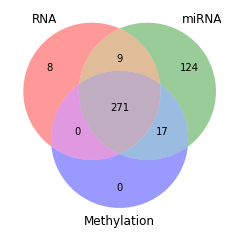

In [7]:
omics = load_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, cancer_type=CANCER_TYPE, norm=True)
X_train, X_test = train_test_split(omics, test_size = .2, random_state = 21, shuffle=True)

## **Best Auto-Encoder & K-Mean Clustering**

In [9]:
# for _ in range(CYCLE):
log_pvalue_l, silhouette_score_l, rna_anovar_f1, rna_rf_f1 = [], [], [], []
mirna_anovar_f1, mirna_rf_f1, mt_anovar_f1, mt_rf_f1 = [], [], [], []
file_name = []

FILE_NAME = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#SAMPLE_GROUP = GROUP_PHTH + CANCER_TYPE + "_GROUP_" + FILE_NAME + ".txt"
file_name.append(FILE_NAME)
print(FILE_NAME)

20220323-083514


In [10]:
## AE(vanilla, sparse, denoisy) - Model compile & Fit
encoder_vanilla = run_ae(X_train=X_train, X_test=X_test, tensorboard_path=TENSORBOARD_PATH)
encoder_sparse = run_ae_sparse(X_train=X_train, X_test=X_test, tensorboard_path=TENSORBOARD_PATH)
encoder_denoisy = run_ae_denoisy(X_train=X_train, X_test=X_test, tensorboard_path=TENSORBOARD_PATH)

In [11]:
group, silhouette_score = best_ae_model(model_list=[encoder_vanilla, encoder_sparse, encoder_denoisy], o=omics,
              group_path=GROUP_PHTH, model_path=MODEL_PATH, cancer_type=CANCER_TYPE, raw_path=RAW_file_path, file_name=FILE_NAME)

INFO:tensorflow:Assets written to: /home/wmbio/WORK/gitworking/Multi-omics-intergration/models/COAD/AE_encoder_vanilla_COAD_20220323-083514/assets
Best AE : encoder_vanilla
Silhouette score : 0.236


20220223-100040
INFO:tensorflow:Assets written to: /home/wmbio/WORK/gitworking/Multi-omics-intergration/models/COAD/AE_encoder_denoisy_COAD_20220223-100040/assets
Best AE : encoder_denoisy
Silhouette score : 0.3471


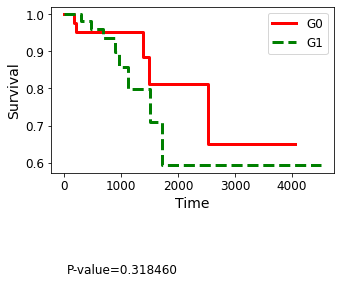

In [5]:
## Sub-group Evalutation
### load preprocess data
omics_preprocess = load_preprocess_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, group=group, norm=True, 
                                               cancer_type=CANCER_TYPE)

### Feature Selection(Anova, RandomForest) for SVM
feature_result = feature_selection_svm(data_type=["rna", "mirna", "mt"], o=omics_preprocess)

### Survival Analysis - logranktest
log_pvalue = log_rank_test(df=omics_preprocess["omics"], png_path=PNG_PATH, file_name=FILE_NAME)

### Score
log_pvalue_l.append(log_pvalue)
silhouette_score_l.append(silhouette_score)

rna_anovar_f1.append(feature_result["rna"][0][2])
rna_rf_f1.append(feature_result["rna"][1][2])

mirna_anovar_f1.append(feature_result["mirna"][0][2])
mirna_rf_f1.append(feature_result["mirna"][1][2])

mt_anovar_f1.append(feature_result["mt"][0][2])
mt_rf_f1.append(feature_result["mt"][1][2])

# session clear
gc.collect()

# Write Score DF
score_df = pd.DataFrame({
'FILENAME' : file_name,
'Log Rank Test' : log_pvalue_l,
'Silhouette' : silhouette_score_l,
'RNA_ANOVA_F1' : rna_anovar_f1,
'RNA_RF_F1' : rna_rf_f1,
'miRNA_ANOVA_F1' : mirna_anovar_f1,
'miRNA_RF_F1' : mirna_rf_f1,
'Methylation_ANOVA_F1' : mt_anovar_f1,
'Methylation_RF_F1' : mt_rf_f1
})

# score table
if not os.path.exists(GROUP_VALIDATION_PATH):
    Path(GROUP_VALIDATION_PATH).mkdir(parents=True, exist_ok=True)
    score_df.to_csv(GROUP_VALIDATION_PATH + "test_validation.csv", index=False, mode='w')
else:
    score_df.to_csv(GROUP_VALIDATION_PATH + "test_validation.csv", index=False, mode='a', header=False)

In [8]:
log_pvalue_l, silhouette_score_l, rna_anovar_f1, rna_rf_f1 = [], [], [], []
mirna_anovar_f1, mirna_rf_f1, mt_anovar_f1, mt_rf_f1 = [], [], [], []
file_name = []

FILE_NAME = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#SAMPLE_GROUP = GROUP_PHTH + CANCER_TYPE + "_GROUP_" + FILE_NAME + ".txt"
file_name.append(FILE_NAME)
print(FILE_NAME)

## AE(vanilla, sparse, denoisy) - Model compile & Fit
encoder_vanilla = run_ae(X_train=X_train, X_test=X_test, tensorboard_path=TENSORBOARD_PATH)
encoder_sparse = run_ae_sparse(X_train=X_train, X_test=X_test, tensorboard_path=TENSORBOARD_PATH)
encoder_denoisy = run_ae_denoisy(X_train=X_train, X_test=X_test, tensorboard_path=TENSORBOARD_PATH)

group, silhouette_score = best_ae_model(model_list=[encoder_vanilla, encoder_sparse, encoder_denoisy], o=omics,
              group_path=GROUP_PHTH, model_path=MODEL_PATH, cancer_type=CANCER_TYPE, file_name=FILE_NAME)

20220308-131334
INFO:tensorflow:Assets written to: /home/wmbio/WORK/gitworking/Multi-omics-intergration/models/BRCA/AE_encoder_denoisy_BRCA_20220308-131334/assets
Best AE : encoder_denoisy
Silhouette score : 0.2192


In [9]:
## Sub-group Evalutation
### load preprocess data
omics_preprocess = load_preprocess_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, group=group, norm=True, 
                                               cancer_type=CANCER_TYPE)

### Feature Selection(Anova, RandomForest) for SVM
feature_result = feature_selection_svm(data_type=["rna", "mirna", "mt"], o=omics_preprocess)

### Survival Analysis - logranktest
log_pvalue = log_rank_test(df=omics_preprocess["omics"], png_path=PNG_PATH, file_name=FILE_NAME)

### Score
log_pvalue_l.append(log_pvalue)
silhouette_score_l.append(silhouette_score)

rna_anovar_f1.append(feature_result["rna"][0][2])
rna_rf_f1.append(feature_result["rna"][1][2])

mirna_anovar_f1.append(feature_result["mirna"][0][2])
mirna_rf_f1.append(feature_result["mirna"][1][2])

mt_anovar_f1.append(feature_result["mt"][0][2])
mt_rf_f1.append(feature_result["mt"][1][2])

# session clear
gc.collect()

# Write Score DF
score_df = pd.DataFrame({
'FILENAME' : file_name,
'Log Rank Test' : log_pvalue_l,
'Silhouette' : silhouette_score_l,
'RNA_ANOVA_F1' : rna_anovar_f1,
'RNA_RF_F1' : rna_rf_f1,
'miRNA_ANOVA_F1' : mirna_anovar_f1,
'miRNA_RF_F1' : mirna_rf_f1,
'Methylation_ANOVA_F1' : mt_anovar_f1,
'Methylation_RF_F1' : mt_rf_f1
})

# # score table
# if not os.path.exists(GROUP_VALIDATION_PATH):
#     Path(GROUP_VALIDATION_PATH).mkdir(parents=True, exist_ok=True)
#     score_df.to_csv(GROUP_VALIDATION_PATH + "test_validation.csv", index=False, mode='w')
# else:
#     score_df.to_csv(GROUP_VALIDATION_PATH + "test_validation.csv", index=False, mode='a', header=False)

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fc75f734940>
Traceback (most recent call last):
  File "/home/wmbio/anaconda3/envs/multiomics-cpu/lib/python3.8/weakref.py", line 345, in remove
KeyboardInterrupt: 

KeyboardInterrupt

R[write to console]: There were 48 warnings (use warnings() to see them)
R[write to console]: 

